## Dev by PuMo
## https://pumo.io/

Classifying the news

Fake and real news dataset on attachments.

In [39]:
import re
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectPercentile,SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns


In [4]:
import nltk
# nltk.download()
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords

In [5]:
import datetime
from pygooglenews import GoogleNews

gn = GoogleNews()

# gn.set_time_range('10/01/2022','11/03/2022')


s = gn.search('Iran', when= '60d')

for entry in s["entries"]:
    print(entry["title"])

# dict_keys(['title', 'title_detail', 'links', 'link', 'id', 'guidislink', 'published', 'published_parsed', 'summary', 'summary_detail', 'source', 'sub_articles'])



2022-10-01
As many as 14,000 arrested in Iran over last six weeks, United Nations says - CNN
Why Aren't Iran's Workers Spearheading a General Strike? - Foreign Policy
Coverage Of Nationwide Protests In Iran On Thursday - ایران اینترنشنال
Iran Protests Surge, Driven by Demonstrators Mourning Their Dead - Bloomberg
Iran: Thousands of Detained Protesters and Activists in Peril - Human Rights Watch
Biden Says Iran Will Be 'Free' in Aside at Campaign Rally - Bloomberg
Opinion | Want to help the Iran protests? Let its soccer team play in the World Cup. - The Washington Post
Iran’s Khamenei Feels Lonely, Isolated, Says Pundit - ایران اینترنشنال
Cleric killed in restive Iranian city, protests rage on - Reuters
"France once again urges Iran to fully respect its international human (...) - France ONU
US Announces New Iran-Related Sanctions - ایران اینترنشنال
Germany Urges Citizens To Leave Iran, Starts Evacuating Embassy - ایران اینترنشنال
Head of Iran's Revolutionary Guards warns that Saturday 

In [6]:
type(s)

dict

In [7]:
pd.options.display.max_colwidth = 128

listTmpContent = []
listTmpSource = []
# lol = pd.DataFrame.from_records(s)

for entry in s["entries"]:
    listTmpContent.append(entry["title"])
    listTmpSource.append(entry["source"]["title"])
#     print(entry["title"])
    
    #gNewsDf=pd.concat(entry["title"])
#gNewsDf = gNewsDf.concat([gNewsDf, entry["title"]], ignore_index=True)
# listTmp
gNewsDf = pd.DataFrame({'content': listTmpContent,
                       'source': listTmpSource,})

gNewsDf = gNewsDf.replace(['ایران اینترنشنال'], 'Iran International')

In [8]:
def process_google_news(text):
    # Cleaning the news Title with regex
    punctuation_regex = re.compile(r'[^\w\s]+')
    
    # remove everything after LAST occurrence of character "-"
    X = ([item for item in text.rsplit('-', 1)[0]])
    X = ''.join(X)
    X = punctuation_regex.sub('', str(X))

#     X = text.apply(lambda x: ''.join([item for item in x.rsplit('-', 1)[0]]))
#     X = X.apply(lambda x: punctuation_regex.sub('', str(x)))
    
    return X

In [9]:
gNewsDf['content'].head().apply(process_google_news)

0    As many as 14000 arrested in Iran over last six weeks United Nations says 
1                        Why Arent Irans Workers Spearheading a General Strike 
2                          Coverage Of Nationwide Protests In Iran On Thursday 
3              Iran Protests Surge Driven by Demonstrators Mourning Their Dead 
4                 Iran Thousands of Detained Protesters and Activists in Peril 
Name: content, dtype: object

In [10]:
gNewsDf['cleancontent'] = gNewsDf['content'].apply(process_google_news)
gNewsDf

,content,source,cleancontent
0,"As many as 14,000 arrested in Iran over last six weeks, United Nations says - CNN",CNN,As many as 14000 arrested in Iran over last six weeks United Nations says
1,Why Aren't Iran's Workers Spearheading a General Strike? - Foreign Policy,Foreign Policy,Why Arent Irans Workers Spearheading a General Strike
2,Coverage Of Nationwide Protests In Iran On Thursday - ایران اینترنشنال,Iran International,Coverage Of Nationwide Protests In Iran On Thursday
3,"Iran Protests Surge, Driven by Demonstrators Mourning Their Dead - Bloomberg",Bloomberg,Iran Protests Surge Driven by Demonstrators Mourning Their Dead
4,Iran: Thousands of Detained Protesters and Activists in Peril - Human Rights Watch,Human Rights Watch,Iran Thousands of Detained Protesters and Activists in Peril
...,...,...,...
84,Iranian official admits that student protesters are being taken to psychiatric institutions - CNN,CNN,Iranian official admits that student protesters are being taken to psychiatric institutions
85,"France urges French nationals to leave Iran ""as soon as possible"" - CNN",CNN,France urges French nationals to leave Iran as soon as possible
86,Opinion | ‘It’s Like a War Out There.’ Iran’s Women Haven’t Been This Angry in a Generation. - The New York Times,The New York Times,Opinion Its Like a War Out There Irans Women Havent Been This Angry in a Generation
87,"19 children among 185 killed during protest unrest in Iran, rights group says - Axios",Axios,19 children among 185 killed during protest unrest in Iran rights group says


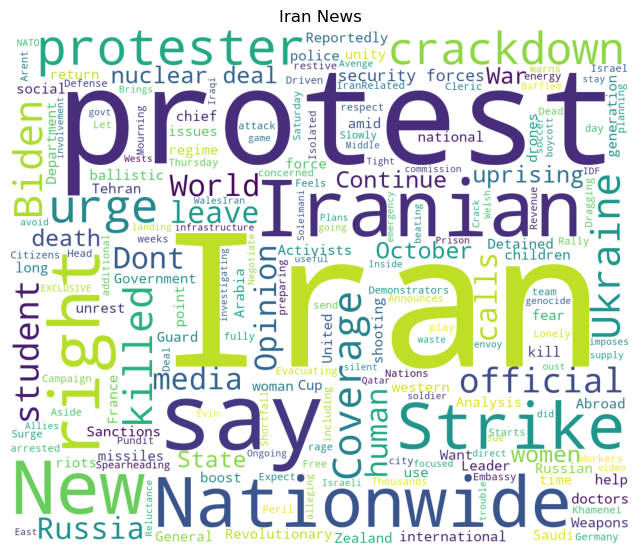

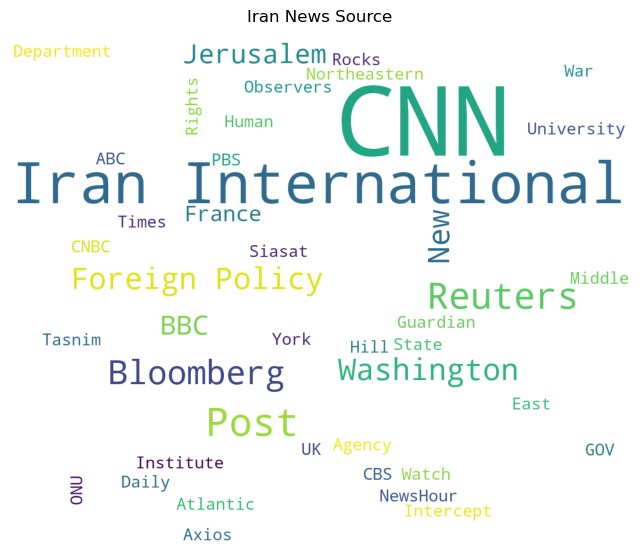

In [11]:
content_join = ' '.join(gNewsDf['cleancontent'])
source_join = ' '.join(gNewsDf['source'])

wordcloud_content = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='white', 
                           width=1200, height=1000).generate(content_join)
wordcloud_source = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='white', 
                           width=1200, height=1000).generate(source_join)

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_content)
plt.axis('off')
plt.title('Iran News')
plt.show()

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_source)
plt.axis('off')
plt.title('Iran News Source')
plt.show()

In [12]:
# Read Fake News Dataset:

fake_df = pd.read_csv('Fake.csv')
fake_df['label'] = 0
fake_df.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to ...",News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of u...",News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secret...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES),"On Christmas day, Donald Trump announced that he would be back to work the following day, but he is golfing for the fourth...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump During His Christmas Speech,Pope Francis used his annual Christmas Day message to rebuke Donald Trump without even mentioning his name. The Pope deliver...,News,"December 25, 2017",0


In [13]:
# Read True News Dataset:

true_df = pd.read_csv('True.csv')
true_df['label'] = 1
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge e...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits on Monday: Pentagon,WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Mond...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaig...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had po...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to s...,politicsNews,"December 29, 2017",1


In [14]:
df = true_df.copy(deep=True)
# df = df.append(fake_df, ignore_index=True)
df = pd.concat([df, fake_df], ignore_index=True)
df

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge e...",politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits on Monday: Pentagon,WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Mond...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaig...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had po...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to s...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated US Sailors Well,"21st Century Wire says As 21WIRE reported earlier this week, the unlikely mishap of two US Naval vessels straying into Ira...",Middle-east,"January 16, 2016",0
44894,"JUSTICE? Yahoo Settles E-mail Privacy Class-action: $4M for Lawyers, $0 for Users","21st Century Wire says It s a familiar theme. Whenever there is a dispute or a change of law, and two tribes go to war, ther...",Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to Take Territorial Booty in Northern Syria,"Patrick Henningsen 21st Century WireRemember when the Obama Administration told the world how it hoped to identify 5,000 re...",Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America Finally Calls it Quits,21st Century Wire says Al Jazeera America will go down in history as one of the biggest failures in broadcast media history....,Middle-east,"January 14, 2016",0


In [15]:
# empty cells
print(df.columns[df.isnull().any()])

Index([], dtype='object')


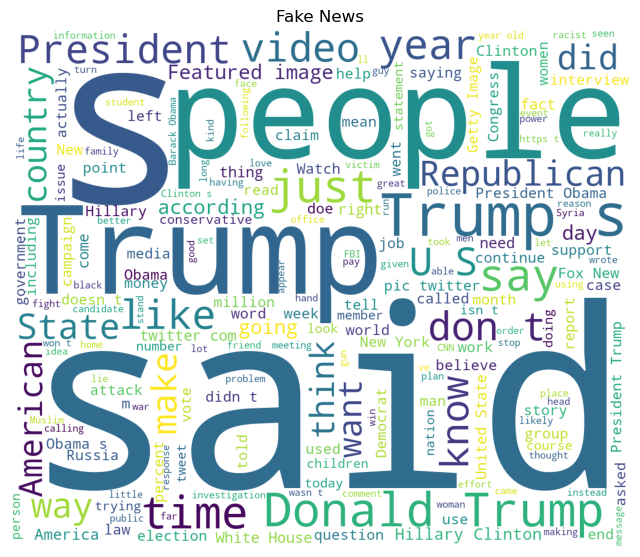

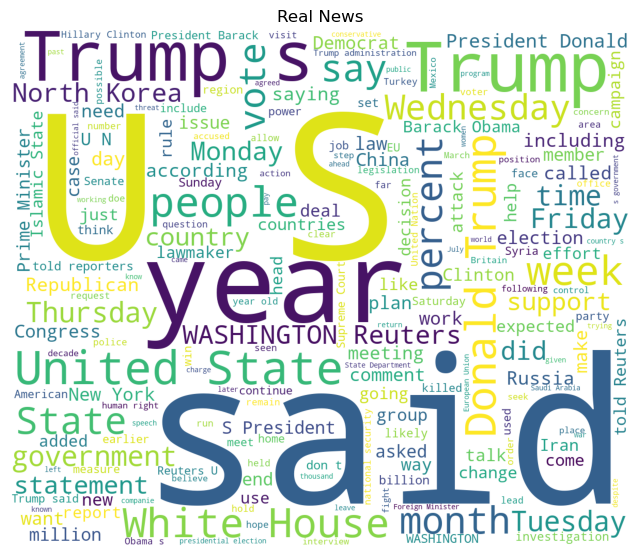

In [43]:
fake_text = ' '.join(fake_df['title']) + ' '.join(fake_df['text'])
true_text = ' '.join(true_df['title']) + ' '.join(true_df['text'])

wordcloud_fake = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='white', 
                           width=1200, height=1000).generate(fake_text)
wordcloud_true = WordCloud(stopwords=ENGLISH_STOP_WORDS,
                           background_color='white', 
                           width=1200, height=1000).generate(true_text)

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_fake)
plt.axis('off')
plt.title('Fake News')
plt.show()

plt.figure(figsize = [8, 7])
plt.imshow(wordcloud_true)
plt.axis('off')
plt.title('Real News')
plt.show()

In [16]:
df.shape

(44898, 5)

In [17]:
df.drop_duplicates(inplace=True)
df.shape

(44689, 5)

In [18]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Check for Class Imbalance

<AxesSubplot:xlabel='label', ylabel='count'>

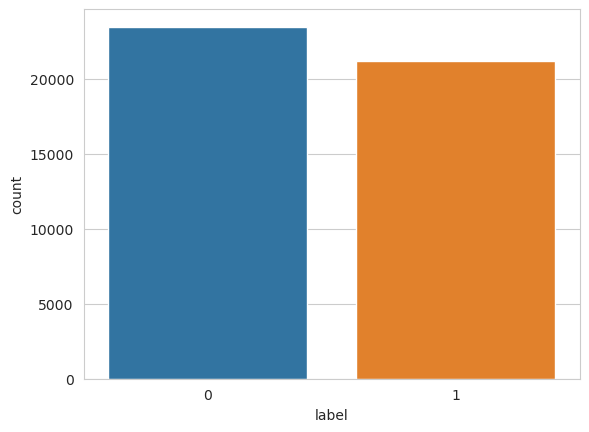

In [49]:
target = df['label']
sns.set_style('whitegrid')
sns.countplot(x=target)

Count Subjects plot

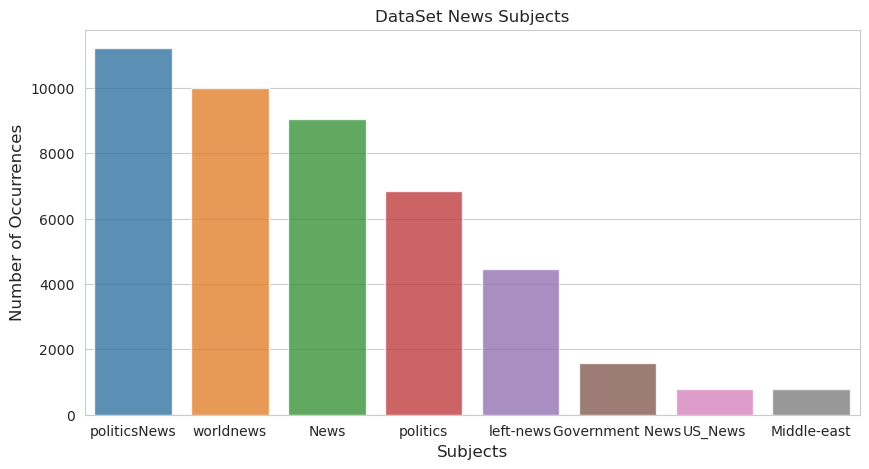

In [48]:
# Plotting a bar graph of the number of tweets in each location, for the first ten locations listed
# in the column 'location'
subject_count  = df['subject'].value_counts()
# location_count = location_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(x=subject_count.index, y=subject_count.values, alpha=0.8)
plt.title('DataSet News Subjects')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Subjects', fontsize=12)
plt.show()

In [24]:
# Data Pre-processing
# Concatenate titles & text
# X = df['title'] + ' ' + df['text']
X = df['title']
y = df['label']

punctuation_regex = re.compile(r'[^\w\s]+')
urls_regex = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+'
                        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+['
                        r'a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-'
                        r'zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')

# Apply data cleaning
X = X.apply(lambda x: urls_regex.sub('', str(x)))
X = X.apply(lambda x: ' '.join([item for item in x.split() if item not in ENGLISH_STOP_WORDS]))
X = X.apply(lambda x: punctuation_regex.sub('', str(x)))

# Split data to 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=10)

Cross validation scores {'fit_time': array([109.88962007, 105.761585  , 106.13423753, 106.10964227,
       105.90334606]), 'score_time': array([3.74106693, 3.6589992 , 3.65499902, 3.69725537, 3.64848709]), 'test_accuracy': array([0.8886869 , 0.8848951 , 0.8820979 , 0.88587413, 0.89062937]), 'test_precision_macro': array([0.88888869, 0.88547684, 0.8828864 , 0.88656665, 0.89139498]), 'test_recall_macro': array([0.88988466, 0.88636569, 0.88369034, 0.88740507, 0.8922155 ]), 'test_f1_macro': array([0.88863322, 0.88486321, 0.88207437, 0.88584808, 0.89060711])}
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4690
           1       0.87      0.93      0.90      4248

    accuracy                           0.90      8938
   macro avg       0.90      0.90      0.90      8938
weighted avg       0.90      0.90      0.90      8938

Accuracy: 0.9013202058626091


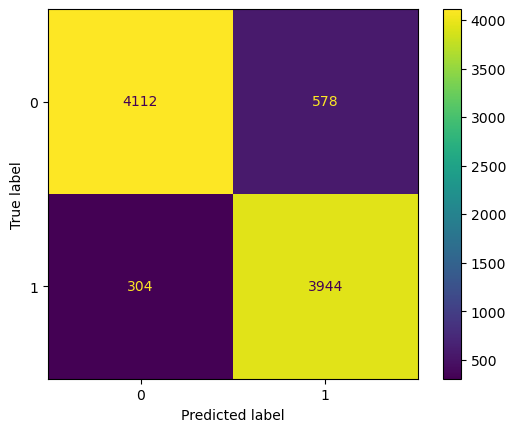

In [26]:
# Random Forests + TF-IDF
# Set up the model pipeline

tweet_tok = TweetTokenizer(strip_handles = True,
                         reduce_len = True)

tf_parameters = {
    'tokenizer': tweet_tok.tokenize,
    'analyzer': 'word',
    'use_idf': False,
    'smooth_idf': True,
    'sublinear_tf': False,
    'ngram_range': (1,2),
    'lowercase': True,
    'stop_words': ENGLISH_STOP_WORDS
}


# tfidf
tfidf = TfidfVectorizer(**tf_parameters)

# feature seelction
fs = SelectPercentile(score_func = chi2, percentile=0.4)

# pipline for the classifier
pipeline = Pipeline(
    [
        ('vect', tfidf),
        ('fs', fs),
        ('clf', RandomForestClassifier(max_features='sqrt', n_estimators=1000, n_jobs=1))
    ]
)

# Creating a StratifiedKFold object with 5 splits
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

scores = cross_validate(pipeline, X_train, y_train,
                        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                        cv=5,
                        n_jobs=1,
                        return_train_score=False)

print('Cross validation scores', scores)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

In [36]:
g_news_labels = pipeline.predict(gNewsDf['cleancontent'])
print(g_news_labels)
g_news_labels = np.where(g_news_labels, 'real', 'fake')
print(g_news_labels)
gNewsDf['predictedLabel'] = g_news_labels
gNewsDf

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1]
['real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'fake' 'fake' 'real' 'real' 'fake' 'real' 'real'
 'real' 'fake' 'real' 'fake' 'real' 'real' 'real' 'real' 'real' 'fake'
 'fake' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'fake'
 'real' 'fake' 'real' 'real' 'real' 'real' 'fake' 'real' 'real' 'fake'
 'real' 'real' 'real' 'real' 'real' 'real' 'fake' 'fake' 'real' 'real'
 'real' 'fake' 'real' 'real' 'real' 'real' 'real' 'real' 'real' 'real'
 'real' 'real' 'real' 'real' 'fake' 'real' 'fake' 'real' 'real']


,content,source,cleancontent,predictedLabel
0,"As many as 14,000 arrested in Iran over last six weeks, United Nations says - CNN",CNN,As many as 14000 arrested in Iran over last six weeks United Nations says,real
1,Why Aren't Iran's Workers Spearheading a General Strike? - Foreign Policy,Foreign Policy,Why Arent Irans Workers Spearheading a General Strike,real
2,Coverage Of Nationwide Protests In Iran On Thursday - ایران اینترنشنال,Iran International,Coverage Of Nationwide Protests In Iran On Thursday,real
3,"Iran Protests Surge, Driven by Demonstrators Mourning Their Dead - Bloomberg",Bloomberg,Iran Protests Surge Driven by Demonstrators Mourning Their Dead,real
4,Iran: Thousands of Detained Protesters and Activists in Peril - Human Rights Watch,Human Rights Watch,Iran Thousands of Detained Protesters and Activists in Peril,real
...,...,...,...,...
84,Iranian official admits that student protesters are being taken to psychiatric institutions - CNN,CNN,Iranian official admits that student protesters are being taken to psychiatric institutions,fake
85,"France urges French nationals to leave Iran ""as soon as possible"" - CNN",CNN,France urges French nationals to leave Iran as soon as possible,real
86,Opinion | ‘It’s Like a War Out There.’ Iran’s Women Haven’t Been This Angry in a Generation. - The New York Times,The New York Times,Opinion Its Like a War Out There Irans Women Havent Been This Angry in a Generation,fake
87,"19 children among 185 killed during protest unrest in Iran, rights group says - Axios",Axios,19 children among 185 killed during protest unrest in Iran rights group says,real


In [28]:
gNewsDf['predictedLabel'].value_counts()

real    73
fake    16
Name: predictedLabel, dtype: int64

In [29]:
gNewsDf['source'].value_counts()

CNN                        25
Iran International         19
Reuters                     6
Bloomberg                   5
The Washington Post         4
Foreign Policy              4
BBC                         3
The Jerusalem Post          3
The Guardian                1
Tasnim News Agency          1
The Siasat Daily            1
Northeastern University     1
CBS News                    1
Department of State         1
The Hill                    1
The New York Times          1
ABC News                    1
The Intercept               1
CNBC                        1
Middle East Institute       1
The France 24 Observers     1
GOV.UK                      1
PBS NewsHour                1
The Atlantic                1
War on the Rocks            1
France ONU                  1
Human Rights Watch          1
Axios                       1
Name: source, dtype: int64

In [33]:
new_df = pd.crosstab(gNewsDf['source'], gNewsDf['predictedLabel'])
# new_df['Fake.Ratio'] 
# new_df['Real.Ratio'] 


In [34]:
new_df

predictedLabel,fake,real
source,,
ABC News,0,1
Axios,0,1
BBC,3,0
Bloomberg,1,4
CBS News,0,1
CNBC,0,1
CNN,6,19
Department of State,0,1
Foreign Policy,0,4


<AxesSubplot:xlabel='source'>

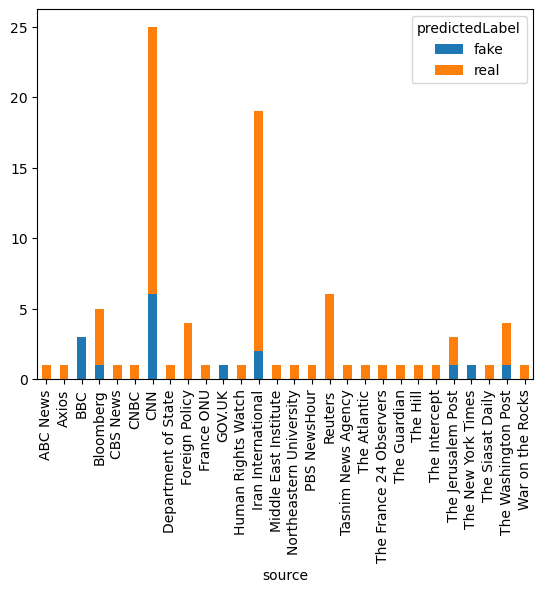

In [38]:
# Creating barplot
pl = new_df.plot(kind="bar", stacked=True, rot=90)
pl